In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from enum import *

In [2]:
#Se controla por medio de estados la clasificacion de todas las muestras de una clase fijada
class EstadosClasificacion(Enum):
    estado1 = "Todas las muestras de la clase 1 están efectivamente en la clase 1"
    estado2 = "Todas las muestras de la clase 2 están efectivamente en la clase 2"
    estado3 = "Se tiene al menos una muestra en la clase equivocada"

#La distancia con signo (ignorando el valor absoluto involucrado en la formula de distancia de un punto a un hiperplano) permite saber la distancia ademas de si el punto se encuentra por encima o por debajo del hiperplano
def calcularDistanciaConSignoPuntoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoMuestra, numeroDimensiones):
    return (np.dot(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones], puntoMuestra) + listaCoeficientesCompletosHiperplanoSeparacion[numeroDimensiones]) / np.linalg.norm(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones])

def evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoMuestra, numeroDimensiones):
    return np.dot(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones], puntoMuestra) + listaCoeficientesCompletosHiperplanoSeparacion[numeroDimensiones]

def generarPuntosMuestra(numeroMuestrasClase1, numeroMuestrasClase2, nombreClase1, nombreClase2, listaCoeficientesCompletosHiperplanoSeparacion, minimoValorCoordenadasPuntos, maximoValorCoordenadasPuntos, numeroDimensiones, margenMinimoSeparacionEntreClases = 1.0):
    muestraPuntos = []
    muestraPuntosPorClases = {nombreClase1: [], nombreClase2: []}
    
    #Se generan los puntos de la primera clase (Se tienen como restricciones que esten a distancia del hiperplano mayor al margen y este por encima del hiperplano, ademas que el punto no se repita)
    for indice in range(numeroMuestrasClase1):
        puntoMuestraValido = False
        while puntoMuestraValido == False:
            puntoGenerado = list(np.random.uniform(low = minimoValorCoordenadasPuntos, high = maximoValorCoordenadasPuntos, size = numeroDimensiones))
            distanciaPuntoHiperplano = calcularDistanciaConSignoPuntoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoGenerado, numeroDimensiones)
            if distanciaPuntoHiperplano > margenMinimoSeparacionEntreClases and puntoGenerado not in muestraPuntosPorClases[nombreClase1]:
                muestraPuntos.append(puntoGenerado)
                muestraPuntosPorClases[nombreClase1].append(puntoGenerado)
                puntoMuestraValido = True
    
    #Se generan los puntos de la segunda clase (Se tienen como restricciones que esten a distancia del hiperplano mayor al margen y este por debajo del hiperplano, ademas que el punto no se repita)
    for indice in range(numeroMuestrasClase2):
        puntoMuestraValido = False
        while puntoMuestraValido == False:
            puntoGenerado = list(np.random.uniform(low = minimoValorCoordenadasPuntos, high = maximoValorCoordenadasPuntos, size = numeroDimensiones))
            distanciaPuntoHiperplano = calcularDistanciaConSignoPuntoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoGenerado, numeroDimensiones)
            if distanciaPuntoHiperplano < -margenMinimoSeparacionEntreClases and puntoGenerado not in muestraPuntosPorClases[nombreClase2]:
                muestraPuntos.append(puntoGenerado)
                muestraPuntosPorClases[nombreClase2].append(puntoGenerado)
                puntoMuestraValido = True
    return muestraPuntos, muestraPuntosPorClases

def verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClaseObjetivo, listaCoeficientesCompletosHiperplano, numeroDimensiones):
    clasePuntoActual = nombreClaseObjetivo
    clasePuntoAnterior = nombreClaseObjetivo
    for punto in muestraPuntosPorClases[nombreClaseObjetivo]:
        clasePuntoAnterior = clasePuntoActual
        valorPunto = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, punto, numeroDimensiones)
        if valorPunto == 0.0:
            return EstadosClasificacion.estado3
        elif np.sign(valorPunto) == 1.0:
            clasePuntoActual = nombreClase1
        else:
            clasePuntoActual = nombreClase2
        
        if clasePuntoActual != clasePuntoAnterior:
            return EstadosClasificacion.estado3
    
    if clasePuntoActual == nombreClase1:
        return EstadosClasificacion.estado1
    elif clasePuntoActual == nombreClase2:
        return EstadosClasificacion.estado2
    return EstadosClasificacion.estado3

def obtenerListasCoordenadasRespectivas(listaPuntos, numeroDimensiones):
    diccionarioPuntosPorCoordenadas = {}
    for indice in range(numeroDimensiones):
        diccionarioPuntosPorCoordenadas[indice] = []
        
    for puntoActual in listaPuntos:
        for indice in range(numeroDimensiones):
            coordenadaActual = puntoActual[indice]
            diccionarioPuntosPorCoordenadas[indice].append(coordenadaActual)
    return diccionarioPuntosPorCoordenadas

#Algoritmo de clasificacion para 2 clases linealmente separables
def algoritmoPerceptronSimple(listaPuntosMuestra, muestraPuntosPorClases, listaInicialCoeficientesCompletosHiperplano, tasaAprendizaje, numeroDimensiones):
    listaCoeficientesCompletosHiperplano = listaInicialCoeficientesCompletosHiperplano
    numeroPasos = 1
    if numeroDimensiones == 1 or numeroDimensiones == 2 or numeroDimensiones == 3:
        plt.ion()
        #plt.show()
    while True:
        if numeroDimensiones == 1 or numeroDimensiones == 2 or numeroDimensiones == 3:
            plt.clf()
        parejaSeleccionada = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
        z = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, parejaSeleccionada, numeroDimensiones)
        if not ((parejaSeleccionada in muestraPuntosPorClases["Clase 1"] and z >= 0) or (parejaSeleccionada in muestraPuntosPorClases["Clase 2"] and z < 0)):
            if z < 0 and parejaSeleccionada in muestraPuntosPorClases["Clase 1"]:
                for i in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[i] = (1 + tasaAprendizaje) * listaCoeficientesCompletosHiperplano[i]
                #listaCoeficientesCompletosHiperplano[0:numeroDimensiones] = (1 + tasaAprendizaje) * listaCoeficientesCompletosHiperplano[0:numeroDimensiones]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] += tasaAprendizaje
                #w1 += alfa * parejaSeleccionada[0]
                #w2 += alfa * parejaSeleccionada[1]
                #b += alfa
            else:
                if z >= 0 and parejaSeleccionada in muestraPuntosPorClases["Clase 2"]:
                    for i in range(numeroDimensiones):
                        listaCoeficientesCompletosHiperplano[i] = (1 - tasaAprendizaje) * listaCoeficientesCompletosHiperplano[i]
                    #listaCoeficientesCompletosHiperplano[0:numeroDimensiones] = (1 - tasaAprendizaje) * listaCoeficientesCompletosHiperplano[0:numeroDimensiones]
                    listaCoeficientesCompletosHiperplano[numeroDimensiones] -= tasaAprendizaje
                    #w1 -= alfa * parejaSeleccionada[0]
                    #w2 -= alfa * parejaSeleccionada[1]
                    #b -= alfa
                    
        """
        #listaPuntosPorCoordenadasRespectivas = obtenerListasCoordenadas(listaPuntos, numeroDimensiones)
        listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
        listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
        #x1, y1 = separarPuntosPorListasDeCoordenadas(muestraPuntosPorClases, "Clase 1")
        #x2, y2 = separarPuntosPorListasDeCoordenadas(muestraPuntosPorClases, "Clase 2")
        x1 = listaPuntosClase1PorCoordenadasRespectivas[0]
        y1 = listaPuntosClase1PorCoordenadasRespectivas[1]
        x2 = listaPuntosClase2PorCoordenadasRespectivas[0]
        y2 = listaPuntosClase2PorCoordenadasRespectivas[1]
        plt.plot(x1, y1, 'bo', label = 'Clase 1 de muestra')
        plt.plot(x2, y2, 'ro', label = 'Clase 2 de muestra')
        listaDeValoresEjeIndependiente = np.arange(minimoEjeX, maximoEjeX, 0.01)
        if listaCoeficientesCompletosHiperplano[numeroDimensiones - 1] != 0:
            plt.plot(listaDeValoresEjeIndependiente, -(listaCoeficientesCompletosHiperplano[numeroDimensiones - 2] * listaDeValoresEjeIndependiente + listaCoeficientesCompletosHiperplano[numeroDimensiones]) / listaCoeficientesCompletosHiperplano[numeroDimensiones - 1], 'g-', label = "Frontera de Decision propuesta por el algoritmo")
        elif listaCoeficientesCompletosHiperplano[numeroDimensiones - 2] != 0:
            #plt.plot(listaDeValoresEjeIndependiente, -(w1 * listaDeValoresEjeIndependiente + b) / w2, 'g-', label = "Frontera de Decision propuesta por el algoritmo")
            c = 0
        plt.legend(loc = 'upper left')
        plt.xlabel('Eje X')
        plt.ylabel('Eje Y')
        plt.title('Visualizacion de la recta que proporciona el algoritmo')
        #plt.xlim(minimoEjeX, maximoEjeX)
        #plt.ylim(minimoEjeY, maximoEjeY)
        plt.grid(True)
        plt.pause(tiempoPausa)
        """
        
        
        
        
        
        
        
        
        
        listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
        listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
        valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
        valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
        valoresCoordenadasYPuntosClase1 = None
        valoresCoordenadasYPuntosClase2 = None
        valoresCoordenadasZPuntosClase1 = None
        valoresCoordenadasZPuntosClase2 = None
        minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
        maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
        minimoEjeY = None
        maximoEjeY = None
        minimoEjeZ = None
        maximoEjeZ = None

        numeroMuestrasHiperplanoClasificacion = 10
        if numeroDimensiones == 1:
            valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
            valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
        elif numeroDimensiones == 2:
            valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
            valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
            minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
            maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
        elif numeroDimensiones == 3:
            valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
            valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
            valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
            valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
            minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
            maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
            minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
            maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

        if numeroDimensiones == 1:
            plt.figure(figsize = (15, 3))
            plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
            plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
            plt.axvline(x = -listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decision (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
            plt.legend(loc = 'upper left')
            plt.xlabel("Eje X")
            plt.ylabel("")
            plt.gca().get_yaxis().set_visible(False)
            plt.title("Visualizacion de Recta de Clasficación que proporciona el Algoritmo del Perceptrón Simple")
            plt.grid(True)
        elif numeroDimensiones == 2:
            listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
            if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
                listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
            elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
                listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

            plt.figure(figsize = (15, 14))
            plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
            plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
            plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'g-', label = "Frontera de Decision (Algoritmo del Perceptrón Simple)")
            plt.legend(loc = 'upper left')
            plt.xlabel("Eje X")
            plt.ylabel("Eje Y")
            plt.title("Visualizacion de Recta de Clasficación que proporciona el Algoritmo del Perceptrón Simple")
            plt.grid(True)
        elif numeroDimensiones == 3:
            listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
            if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
                listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
                listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
            elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
                listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
                listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]
            elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] != 0.0:
                listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
                listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion

            fig = plt.figure(figsize = (15, 14))
            ax = fig.add_subplot(111, projection = '3d')
            ax.view_init(elev = 30, azim = 60)
            ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o', label = "Muestras de la Clase 1")
            ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o', label = "Muestras de la Clase 2")
            ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'g', alpha = 0.35)
            ax.set_xlabel("Eje X")
            ax.set_ylabel("Eje Y")
            ax.set_zlabel("Eje Z")
            plt.title("Visualizacion de Plano de Clasficación que proporciona el Algoritmo del Perceptrón Simple")
            plt.legend()
            plt.tight_layout()
        
        
        
        
        
        
        
        
        
        #revisionClasificacion1 = revisarClasificacionLineal(clases, '1', w1, w2, b)
        #revisionClasificacion2 = revisarClasificacionLineal(clases, '2', w1, w2, b)
        revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, "Clase 1", listaCoeficientesCompletosHiperplano, numeroDimensiones)
        revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, "Clase 2", listaCoeficientesCompletosHiperplano, numeroDimensiones)
        numeroPasos += 1
        #if revisionClasificacion1 != 0 and revisionClasificacion2 != 0 and revisionClasificacion1 != revisionClasificacion2:
        if revisionClasificacion1 == True and revisionClasificacion2 == True:
            print("Fue(ron) necesario(s)", numeroPasos, "paso(s) para obtener una recta de clasificacion")
            print("La recta de clasificacion que proporciona el algoritmo es " + str(w1) + "x + " + str(w2) + "y + " + str(b) + " = 0")
            break
    
    
        if numeroDimensiones == 1 or numeroDimensiones == 2 or numeroDimensiones == 3:
            plt.pause(tiempoPausaAnimacion)
            plt.ioff()
            plt.show()

In [3]:
#Parametros de ejecucion del programa
tasaAprendizaje = 0.001
numeroDimensiones = 3
minimoValorCoordenadasPuntos = -20.0
maximoValorCoordenadasPuntos = 20.0
listaCoeficientesPrincipalesHiperplanoBase = [1.0] * numeroDimensiones
coeficienteInterceptoHiperplanoBase = -5.0
nombreClase1 = "Clase 1"
nombreClase2 = "Clase 2"
margenMinimoSeparacionEntreClases = 3.5
numeroMuestrasClase1 = 50
numeroMuestrasClase2 = 50
tiempoPausaAnimacion = 0.001

In [4]:
listaCoeficientesCompletosHiperplanoBase = listaCoeficientesPrincipalesHiperplanoBase + [coeficienteInterceptoHiperplanoBase]
listaPuntosMuestra, muestraPuntosPorClases = generarPuntosMuestra(numeroMuestrasClase1, numeroMuestrasClase2, nombreClase1, nombreClase2, listaCoeficientesCompletosHiperplanoBase, minimoValorCoordenadasPuntos, maximoValorCoordenadasPuntos, numeroDimensiones, margenMinimoSeparacionEntreClases = margenMinimoSeparacionEntreClases)

In [5]:
#Este bloque de codigo se puede comentar para que el hiperplano propuesto inicialmente separe perfectamente las muestras de las 2 clases y por lo tanto no se ejecuta el algoritmo del perceptron simple
listaCoeficientesCompletosHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))
while listaCoeficientesCompletosHiperplanoBase[0:numeroDimensiones] == [0] * numeroDimensiones:
    listaCoeficientesCompletosHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))

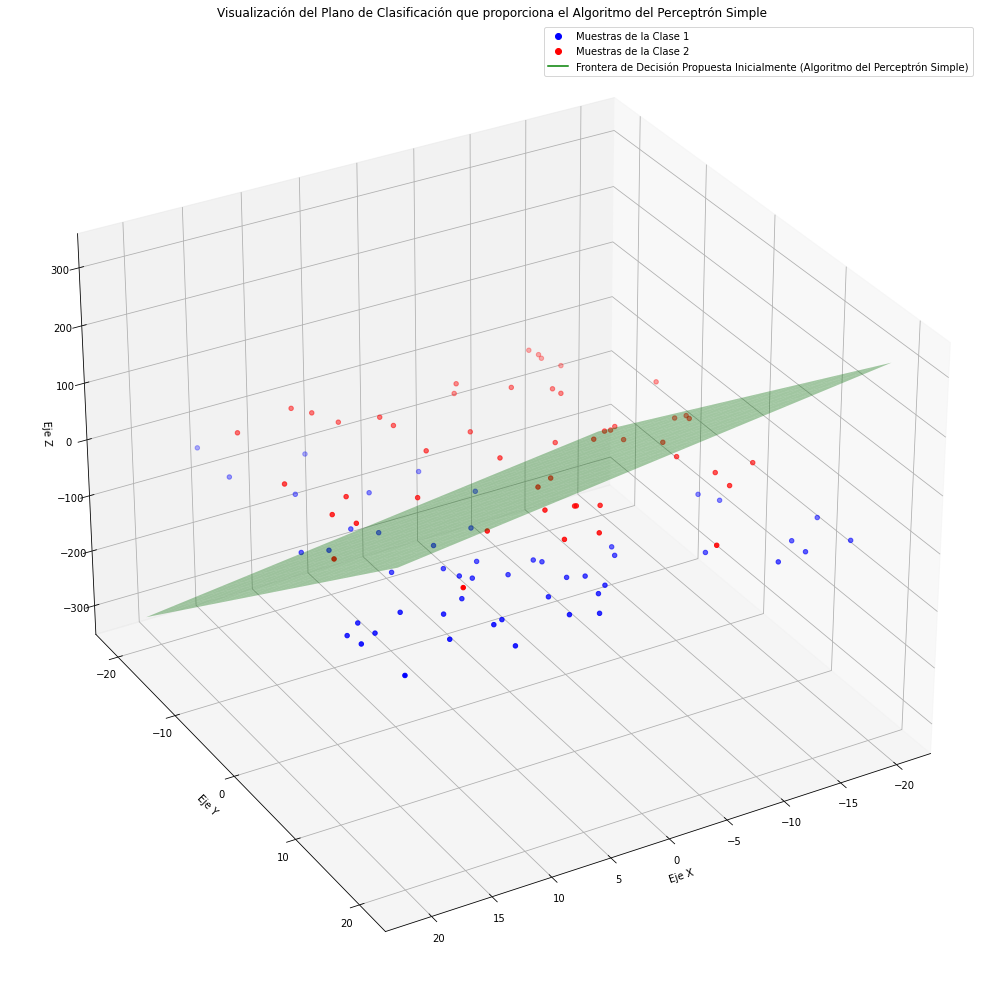

In [6]:
listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
valoresCoordenadasYPuntosClase1 = None
valoresCoordenadasYPuntosClase2 = None
valoresCoordenadasZPuntosClase1 = None
valoresCoordenadasZPuntosClase2 = None
minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
minimoEjeY = None
maximoEjeY = None
minimoEjeZ = None
maximoEjeZ = None

numeroMuestrasHiperplanoClasificacion = 20
if numeroDimensiones == 1:
    valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
    valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
    
    plt.figure(figsize = (15, 3))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.axvline(x = -listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("")
    plt.gca().get_yaxis().set_visible(False)
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 2:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

    plt.figure(figsize = (15, 14))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'g-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)")
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
    valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
        listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    currentFigure = plt.figure(figsize = (15, 14))
    ax = currentFigure.add_subplot(111, projection = '3d')
    ax.view_init(elev = 30, azim = 60)
    ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
    etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
    ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
    etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'g', alpha = 0.35)
    etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlano], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)"], numpoints = 1)
    plt.tight_layout()
    plt.show()

In [7]:
#algoritmoPerceptronSimple(listaPuntosMuestra, muestraPuntosPorClases, listaCoeficientesCompletosHiperplanoBase, tasaAprendizaje, numeroDimensiones)

In [8]:
%matplotlib

listaCoeficientesCompletosHiperplano = listaCoeficientesCompletosHiperplanoBase
numeroPasos = 0
if numeroDimensiones == 1:
    plt.ion()
    while True:
        plt.clf()
        puntoMuestraSeleccionado = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
        valorPuntoMuestraSeleccionado = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, puntoMuestraSeleccionado, numeroDimensiones)
        if not ((valorPuntoMuestraSeleccionado >= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]) or (valorPuntoMuestraSeleccionado <= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2])):
            if valorPuntoMuestraSeleccionado < 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] += tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] += tasaAprendizaje
            elif valorPuntoMuestraSeleccionado > 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] -= tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] -= tasaAprendizaje

        listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
        listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
        valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
        valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
        valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
        valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
        minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
        maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1

        plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
        plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
        plt.axvline(x = -listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
        plt.legend(loc = 'upper left')
        plt.xlabel("Eje X")
        plt.ylabel("")
        plt.gca().get_yaxis().set_visible(False)
        plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
        plt.grid(True)
        
        revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase1, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase2, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        numeroPasos += 1
        if revisionClasificacion1.value == EstadosClasificacion.estado1.value and revisionClasificacion2.value == EstadosClasificacion.estado2.value:
            print("Fue(ron) necesario(s)", numeroPasos, "paso(s) para obtener una recta de clasificacion")
            #print("La recta de clasificacion que proporciona el algoritmo es " + str(w1) + "x + " + str(w2) + "y + " + str(b) + " = 0")
            break
            
        plt.pause(tiempoPausaAnimacion)
        plt.ioff()
        plt.show()
elif numeroDimensiones == 2:
    plt.ion()
    while True:
        plt.clf()
        puntoMuestraSeleccionado = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
        valorPuntoMuestraSeleccionado = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, puntoMuestraSeleccionado, numeroDimensiones)
        if not ((valorPuntoMuestraSeleccionado >= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]) or (valorPuntoMuestraSeleccionado <= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2])):
            if valorPuntoMuestraSeleccionado < 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] += tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] += tasaAprendizaje
            elif valorPuntoMuestraSeleccionado > 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] -= tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] -= tasaAprendizaje
        
        listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
        listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
        valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
        valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
        valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
        valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
        minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
        maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
        minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
        maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1

        listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
        listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
        if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
            listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
        elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
            listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion
        
        plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
        plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
        plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'g-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)")
        plt.legend(loc = 'upper left')
        plt.xlabel("Eje X")
        plt.ylabel("Eje Y")
        plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
        plt.grid(True)
        
        revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase1, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase2, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        numeroPasos += 1
        if revisionClasificacion1.value == EstadosClasificacion.estado1.value and revisionClasificacion2.value == EstadosClasificacion.estado2.value:
            print("Fue(ron) necesario(s)", numeroPasos, "paso(s) para obtener una recta de clasificacion")
            #print("La recta de clasificacion que proporciona el algoritmo es " + str(w1) + "x + " + str(w2) + "y + " + str(b) + " = 0")
            break
            
        plt.pause(tiempoPausaAnimacion)
        plt.ioff()
        plt.show()
elif numeroDimensiones == 3:
    currentFigure = plt.figure()
    ax = currentFigure.add_subplot(111, projection = '3d')
    plt.ion()
    while True:
        ax.cla()
        puntoMuestraSeleccionado = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
        valorPuntoMuestraSeleccionado = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, puntoMuestraSeleccionado, numeroDimensiones)
        if not ((valorPuntoMuestraSeleccionado >= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]) or (valorPuntoMuestraSeleccionado <= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2])):
            if valorPuntoMuestraSeleccionado < 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] += tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] += tasaAprendizaje
            elif valorPuntoMuestraSeleccionado > 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] -= tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] -= tasaAprendizaje

        listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
        listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
        valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
        valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
        valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
        valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
        valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
        valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
        minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
        maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
        minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
        maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
        minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
        maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1
        
        listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
        listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
        listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
        if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
            listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
            listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
        elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
            listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
            listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]
        elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] != 0.0:
            listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
            listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
        
        ax.view_init(elev = 30, azim = 60)
        ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
        etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
        ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
        etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
        ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'g', alpha = 0.35)
        etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
        ax.set_xlabel("Eje X")
        ax.set_ylabel("Eje Y")
        ax.set_zlabel("Eje Z")
        ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
        ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlano], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)"], numpoints = 1)
        plt.tight_layout()
        
        revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase1, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase2, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        numeroPasos += 1
        if revisionClasificacion1.value == EstadosClasificacion.estado1.value and revisionClasificacion2.value == EstadosClasificacion.estado2.value:
            print("Fue(ron) necesario(s)", numeroPasos, "paso(s) para obtener una recta de clasificacion")
            #print("La recta de clasificacion que proporciona el algoritmo es " + str(w1) + "x + " + str(w2) + "y + " + str(b) + " = 0")
            break
        
        plt.pause(tiempoPausaAnimacion)
        plt.ioff()
        plt.show()



Using matplotlib backend: TkAgg
Fue(ron) necesario(s) 1802 paso(s) para obtener una recta de clasificacion


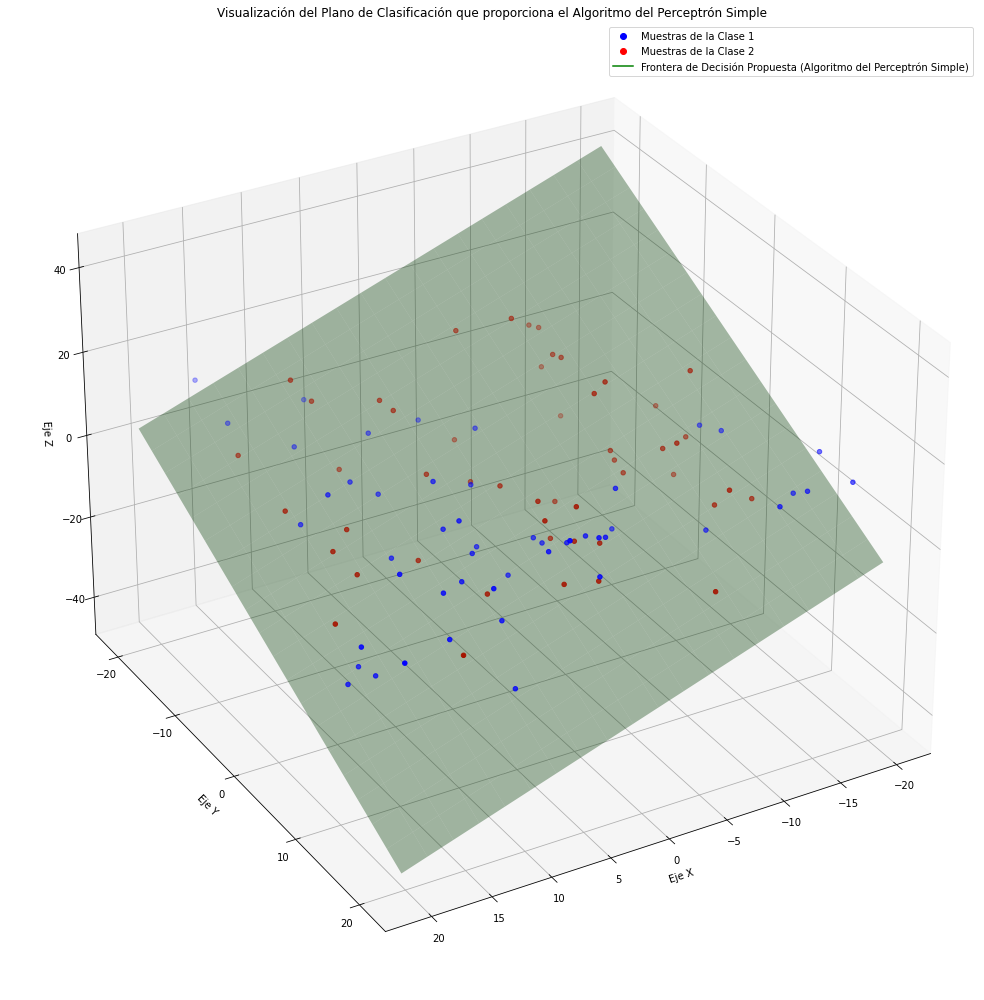

In [9]:
%matplotlib inline

listaCoeficientesCompletosHiperplano = listaCoeficientesCompletosHiperplanoBase
numeroPasos = 0
if numeroDimensiones == 1:
    listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
    listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
    valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
    valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
    valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
    valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
    minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
    maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
    
    plt.figure(figsize = (15, 3))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.axvline(x = -listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("")
    plt.gca().get_yaxis().set_visible(False)
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 2:
    listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
    listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
    valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
    valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
    maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion
    
    plt.figure(figsize = (15, 14))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'g-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)")
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
    listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
    valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
    valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
    valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
    minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
    maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
        listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    currentFigure = plt.figure(figsize = (15, 14))
    ax = currentFigure.add_subplot(111, projection = '3d')
    ax.view_init(elev = 30, azim = 60)
    ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
    etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
    ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
    etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'g', alpha = 0.35)
    etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlano], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)"], numpoints = 1)
    plt.tight_layout()
    plt.show()